 # Predicting movie's revenue

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from random import randrange


 ## Import and process CSV
  * Remove row which contain empty cell
  * Reset Index for easier preprocessing step

In [2]:
url = ('./src/IMDB-Movie-Data.csv')
csv = pd.read_csv(url, sep=",")
csv = csv.dropna(axis="index", how="any")
csv = csv.reset_index(drop=True)
csv.head()


,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


  ## Feature & target selection
  * Select relevant feature (excluding XYZ)
  * Feature "Description" was removed because NLP (Natural Language Processing) isn't used
  * Feature "Metascore" was selected because Metascore usually comes out before movie release
  * On data pre-processing step we will remove some feature

In [3]:
x = csv[["Genre", "Director", "Actors",
         "Runtime (Minutes)", "Rating", "Votes", "Metascore", "Year"]]
y = csv["Revenue (Millions)"].copy(deep=True)

x.head()


,Genre,Director,Actors,Runtime (Minutes),Rating,Votes,Metascore,Year
0,"Action,Adventure,Sci-Fi",James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",121,8.1,757074,76.0,2014
1,"Adventure,Mystery,Sci-Fi",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",124,7.0,485820,65.0,2012
2,"Horror,Thriller",M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",117,7.3,157606,62.0,2016
3,"Animation,Comedy,Family",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",108,7.2,60545,59.0,2016
4,"Action,Adventure,Fantasy",David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",123,6.2,393727,40.0,2016


  ## Data pre-processing #1
  * Convert feature "Genre" & "Actors" data type from string to list because a movie could have more than a genre and an actor
  * Change feature "Year" into movie age (since release year)
  * Rename column for convenience sake

In [4]:
list_genre = []
for i in range(0, x["Genre"].size):
    list_genre.append(x["Genre"][i].split(','))
x["Genre"].update(pd.Series(list_genre))

list_actors = []
for i in range(0, x["Actors"].size):
    list_actors.append(x["Actors"][i].split(','))
x["Actors"].update(pd.Series(list_actors))

# Column position, column name, column value
x.insert(3, "Age", [2019] - x["Year"])
x = x.rename(columns={"Runtime (Minutes)": "Runtime"})
x = x.drop(columns=["Year"])

x.head()


,Genre,Director,Actors,Age,Runtime,Rating,Votes,Metascore
0,"[Action, Adventure, Sci-Fi]",James Gunn,"[Chris Pratt, Vin Diesel, Bradley Cooper, Z...",5,121,8.1,757074,76.0
1,"[Adventure, Mystery, Sci-Fi]",Ridley Scott,"[Noomi Rapace, Logan Marshall-Green, Michael...",7,124,7.0,485820,65.0
2,"[Horror, Thriller]",M. Night Shyamalan,"[James McAvoy, Anya Taylor-Joy, Haley Lu Ric...",3,117,7.3,157606,62.0
3,"[Animation, Comedy, Family]",Christophe Lourdelet,"[Matthew McConaughey, Reese Witherspoon, Seth...",3,108,7.2,60545,59.0
4,"[Action, Adventure, Fantasy]",David Ayer,"[Will Smith, Jared Leto, Margot Robbie, Vio...",3,123,6.2,393727,40.0


  ## Data pre-processing #2
  Perform normalization to all features which uses number/decimal. Normalization usually have range -1 to -1 or 0 to 1.

In [5]:
ndarray_runtime = np.array(x["Runtime"])
ndarray_metascore = np.array(x["Metascore"])
ndarray_age = np.array(x["Age"])
ndarray_rating = np.array(x["Rating"])
ndarray_votes = np.array(x["Votes"])

interp_runtime = np.interp(
    ndarray_runtime, (0, ndarray_runtime.max()), (0, +3))
interp_metascore = np.interp(
    ndarray_metascore, (0, ndarray_metascore.max()), (0, +4))
interp_age = np.interp(ndarray_age, (0, ndarray_age.max()), (0, +1))
interp_rating = np.interp(ndarray_rating, (0, ndarray_rating.max()), (0, +5))
interp_votes = np.interp(ndarray_votes, (0, ndarray_votes.max()), (0, +1))

x["Runtime"].update(pd.Series(interp_runtime))
x["Metascore"].update(pd.Series(interp_metascore))
x["Age"].update(pd.Series(interp_age))
x["Rating"].update(pd.Series(interp_rating))
x["Votes"].update(pd.Series(interp_votes))

x.head()


,Genre,Director,Actors,Age,Runtime,Rating,Votes,Metascore
0,"[Action, Adventure, Sci-Fi]",James Gunn,"[Chris Pratt, Vin Diesel, Bradley Cooper, Z...",0.384615,1.941176,4.500000,0.422494,3.04
1,"[Adventure, Mystery, Sci-Fi]",Ridley Scott,"[Noomi Rapace, Logan Marshall-Green, Michael...",0.538462,1.989305,3.888889,0.271118,2.60
2,"[Horror, Thriller]",M. Night Shyamalan,"[James McAvoy, Anya Taylor-Joy, Haley Lu Ric...",0.230769,1.877005,4.055556,0.087954,2.48
3,"[Animation, Comedy, Family]",Christophe Lourdelet,"[Matthew McConaughey, Reese Witherspoon, Seth...",0.230769,1.732620,4.000000,0.033788,2.36
4,"[Action, Adventure, Fantasy]",David Ayer,"[Will Smith, Jared Leto, Margot Robbie, Vio...",0.230769,1.973262,3.444444,0.219724,1.60


  ## Data pre-processing #3
  Using one-hot encode technique for feature which uses string

In [6]:
ohe_director = pd.get_dummies(x["Director"])

series_genre = pd.Series()
for i in range(0, x["Genre"].size):
    tmp_series = pd.Series(x["Genre"][i])
    series_genre.at[i] = tmp_series
ohe_genre = pd.get_dummies(series_genre.apply(
    pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)

series_actors = pd.Series()
for i in range(0, x["Actors"].size):
    tmp_series = pd.Series(x["Actors"][i])
    series_actors.at[i] = tmp_series
ohe_actors = pd.get_dummies(series_actors.apply(
    pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)

print(ohe_director.sample())
print(ohe_genre.sample())
print(ohe_actors.sample())


Aamir Khan  Abdellatif Kechiche  Adam McKay  Adam Shankman  Adam Wingard  \
311           0                    0           0              0             0   

     Akiva Schaffer  Alan Taylor  Albert Hughes  Alejandro Amenábar  \
311               0            0              0                   0   

     Alejandro González Iñárritu  ...  Wes Craven  Whit Stillman  Will Gluck  \
311                            0  ...           0              0           0   

     William Brent Bell  Woody Allen  Xavier Dolan  Yimou Zhang  \
311                   0            0             0            0   

     Yorgos Lanthimos  Zack Snyder  Zackary Adler  
311                 0            0              0  

[1 rows x 524 columns]
     Action  Adventure  Animation  Biography  Comedy  Crime  Drama  Fantasy  \
418       0          0          0          1       0      0      1        0   

     Horror  Mystery  Sci-Fi  Thriller  Family  History  Music  Musical  \
418       0        0       0         0   

  ## Data pre-processing #4
  Remove all row where frequency of one-hot encoded feature is too low or have extremely low correlation with target

  This method is used to improve accuracy of trained model and only used with small amount of traning data

In [7]:
min_freq_director = 4
min_freq_genre = 6
min_freq_actors = 4

min_corr_director = 0.12
min_corr_genre = 0.14
min_corr_actors = 0.13

corr_director = []
corr_genre = []
corr_actors = []

ctr = 0
for col in ohe_director.columns:
    freq = np.sum(np.array(ohe_director[col]))
    corr = np.abs(ohe_director[col].corr(y))
    corr_director.append(corr)
    if freq < min_freq_director or corr < min_corr_director:
        ohe_director = ohe_director.drop(columns=[col])
    else:
        ctr += 1
print(
    f"Count of eligable feature 'Director' (>= {min_freq_director} && >= {min_corr_director * 100}%) : {ctr}")
print(
    f"Average correlation for feature 'Director' : {np.average(np.array(corr_director))}")


ctr = 0
for col in ohe_genre.columns:
    freq = np.sum(np.array(ohe_genre[col]))
    corr = np.abs(ohe_genre[col].corr(y))
    corr_genre.append(corr)
    if freq < min_freq_genre or corr < min_corr_genre:
        ohe_genre = ohe_genre.drop(columns=[col])
    else:
        ctr += 1
print(
    f"Count of eligable feature 'Genre' (>= {min_freq_genre} && >= {min_corr_genre * 100}%) : {ctr}")
print(
    f"Average correlation for feature 'Genre' : {np.average(np.array(corr_genre))}")

ctr = 0
for col in ohe_actors.columns:
    freq = np.sum(np.array(ohe_actors[col]))
    corr = abs(ohe_actors[col].corr(y))
    corr_actors.append(corr)
    if freq < min_freq_actors or corr < min_corr_actors:
        ohe_actors = ohe_actors.drop(columns=[col])
    else:
        ctr += 1
print(
    f"Count of eligable feature 'Actors' (>= {min_freq_actors} && >= {min_corr_actors * 100}%) : {ctr}")
print(
    f"Average correlation for feature 'Actors' : {np.average(np.array(corr_actors))}")


Count of eligable feature 'Director' (>= 4 && >= 12.0%) : 5
Average correlation for feature 'Director' : 0.026131990654064866
Count of eligable feature 'Genre' (>= 6 && >= 14.000000000000002%) : 8
Average correlation for feature 'Genre' : 0.13055833391199706
Count of eligable feature 'Actors' (>= 4 && >= 13.0%) : 9
Average correlation for feature 'Actors' : 0.02479529248295699


  ## Data pre-processing #5A
  * Add filtered one-hot encoded feature into feature DataFrame
  * See correlation between each feature & target

In [8]:
show_ohe_corr = True

corr = pd.concat([x, ohe_director, ohe_genre, ohe_actors, y], axis=1,
                 sort=False) if show_ohe_corr else pd.concat([x, y], axis=1, sort=False)
corr.corr(method='pearson')


,Age,Runtime,Rating,Votes,Metascore,Christopher Nolan,David Yates,Francis Lawrence,J.J. Abrams,Michael Bay,...,Jennifer Lawrence,Robert Downey Jr.,Shia LaBeouf,Domhnall Gleeson,Josh Hutcherson,Liam Hemsworth,Zoe Saldana,Michelle Rodriguez,Rupert Grint,Revenue (Millions)
Age,1.000000,0.101933,0.145703,0.362445,0.062303,0.061266,0.026977,0.005617,0.041717,0.022513,...,-0.043215,0.031188,0.082070,-0.051142,-0.016931,-0.026593,-0.017665,0.038383,0.071148,0.129198
Runtime,0.101933,1.000000,0.374566,0.399298,0.221397,0.159323,0.093669,0.045438,0.050202,0.151939,...,0.087740,0.096324,0.100774,0.067829,0.056917,0.063000,0.046133,0.034183,0.101712,0.281721
Rating,0.145703,0.374566,1.000000,0.517452,0.672731,0.164773,0.059924,0.016632,0.067623,-0.032041,...,0.019427,0.078138,-0.024814,0.078221,-0.010096,0.014748,0.064764,-0.007051,0.069921,0.217106
Votes,0.362445,0.399298,0.517452,1.000000,0.332674,0.449067,0.064134,0.076503,0.097056,0.040128,...,0.075541,0.184927,0.052795,0.059710,0.071778,0.067979,0.092009,0.072862,0.081755,0.636833
Metascore,0.062303,0.221397,0.672731,0.332674,1.000000,0.069621,0.044734,0.032394,0.068707,-0.078904,...,0.033257,0.006808,-0.058556,0.076023,0.005601,0.011319,0.059771,-0.009505,0.064073,0.142397
Christopher Nolan,0.061266,0.159323,0.164773,0.449067,0.069621,1.000000,-0.006579,-0.005365,-0.006002,-0.006579,...,-0.007111,-0.007606,-0.005365,-0.006002,-0.006002,-0.006579,-0.006579,-0.005365,-0.005365,0.162024
David Yates,0.026977,0.093669,0.059924,0.064134,0.044734,-0.006579,1.000000,-0.005881,-0.006579,-0.007212,...,-0.007794,-0.008337,-0.005881,-0.006579,-0.006579,-0.007212,-0.007212,-0.005881,0.815517,0.152177
Francis Lawrence,0.005617,0.045438,0.016632,0.076503,0.032394,-0.005365,-0.005881,1.000000,-0.005365,-0.005881,...,0.564337,-0.006799,-0.004796,-0.005365,0.669077,0.610167,-0.005881,-0.004796,-0.004796,0.159374
J.J. Abrams,0.041717,0.050202,0.067623,0.097056,0.068707,-0.006002,-0.006579,-0.005365,1.000000,-0.006579,...,-0.007111,-0.007606,-0.005365,0.195198,-0.006002,-0.006579,0.177201,-0.005365,-0.005365,0.186998
Michael Bay,0.022513,0.151939,-0.032041,0.040128,-0.078904,-0.006579,-0.007212,-0.005881,-0.006579,1.000000,...,-0.007794,-0.008337,0.610167,-0.006579,-0.006579,-0.007212,-0.007212,-0.005881,-0.005881,0.123833


  ## Data pre-processing #5B
  * Remove all irrelevant features
  * Add polynomial features degree 2

In [9]:
use_polynomial = True

x = x.drop(columns=["Director", "Genre", "Actors"])
x = x.drop(columns=["Rating", "Age"])

if use_polynomial:
    x_poly = PolynomialFeatures(
        2, include_bias=True, interaction_only=False).fit_transform(x)
    x = pd.concat([x, pd.DataFrame(x_poly)], axis=1, sort=False)

x = pd.concat([x, ohe_director, ohe_genre, ohe_actors], axis=1, sort=False)

print(f"Total feature : {x.shape[1]}")
x.head()


Total feature : 35


,Runtime,Votes,Metascore,0,1,2,3,4,5,6,...,Romance,Jennifer Lawrence,Robert Downey Jr.,Shia LaBeouf,Domhnall Gleeson,Josh Hutcherson,Liam Hemsworth,Zoe Saldana,Michelle Rodriguez,Rupert Grint
0,1.941176,0.422494,3.04,1.0,1.941176,0.422494,3.04,3.768166,0.820136,5.901176,...,0,0,0,0,0,0,0,1,0,0
1,1.989305,0.271118,2.60,1.0,1.989305,0.271118,2.60,3.957334,0.539336,5.172193,...,0,0,0,0,0,0,0,0,0,0
2,1.877005,0.087954,2.48,1.0,1.877005,0.087954,2.48,3.523149,0.165090,4.654973,...,0,0,0,0,0,0,0,0,0,0
3,1.732620,0.033788,2.36,1.0,1.732620,0.033788,2.36,3.001973,0.058542,4.088984,...,0,0,0,0,0,0,0,0,0,0
4,1.973262,0.219724,1.60,1.0,1.973262,0.219724,1.60,3.893763,0.433573,3.157219,...,0,0,0,0,0,0,0,0,0,0


  ## Split training & test data
  * Split into 70/30 due to small training data
  * 80/20 or lower is preffered if there are more traning data
  * Sort x_train for visualization convience

In [10]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

x_test = pd.concat([x_test, y_test], axis=1)
x_test = x_test.sort_values(by="Revenue (Millions)")
y_test = x_test.take([35], axis=1)
y_test = y_test.iloc[:,0]
x_test = x_test.drop(columns=["Revenue (Millions)"])


  ## Training phase
  3 layers were used with dynamic amount of node

In [11]:
hls = (x.shape[1], int(x.shape[1]*0.7), int(x.shape[1]*0.49))

print(f'Hidden layer/node : {hls}')

mlpr = MLPRegressor(
    hidden_layer_sizes=hls,
    activation='relu',
    solver='adam',
    alpha=0.00011,
    learning_rate='adaptive',
    learning_rate_init=0.00111,
    max_iter=5000,
    shuffle=False,
    tol=0.0001,
    momentum=0.9,
    verbose=False
)
mlpr_model = mlpr.fit(x_train, y_train)

print(f"Training iteration : {mlpr_model.n_iter_}")


Hidden layer/node : (35, 24, 17)
Training iteration : 817


  ## Testing phase & result
  * Show MSE score of train phase
  * Show MSE, R2 and variance score of test phase

In [12]:
mlpr_predict = mlpr.predict(x_test)

mse = mean_squared_error(y_test, mlpr_predict)
r2 = r2_score(y_test, mlpr_predict)
evs = explained_variance_score(y_test, mlpr_predict)

print(f"MSE train : {mlpr_model.loss_}")
print(f"MSE test : {mse}")
print(f"R2 score : {r2}")
print(f"Variance score : {evs}")


MSE train : 1741.9043020872298
MSE test : 3731.461466231341
R2 score : 0.4599096411820113
Variance score : 0.46064367945064333


 ## Training Loss Curve

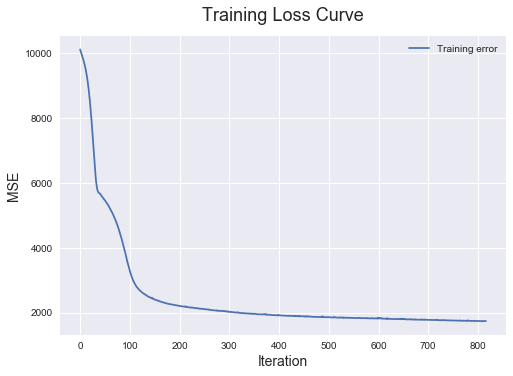

In [13]:
plt.style.use('seaborn')
plt.plot([i for i in range(mlpr_model.n_iter_)],
         mlpr_model.loss_curve_, label='Training error')
plt.ylabel('MSE', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.title('Training Loss Curve', fontsize=18, y=1.03)
plt.legend()


  ## MSE score with different training size and cross-validation method

[learning_curve] Training set sizes: [ 83 167 251 335 419 502 586 670]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   12.7s finished


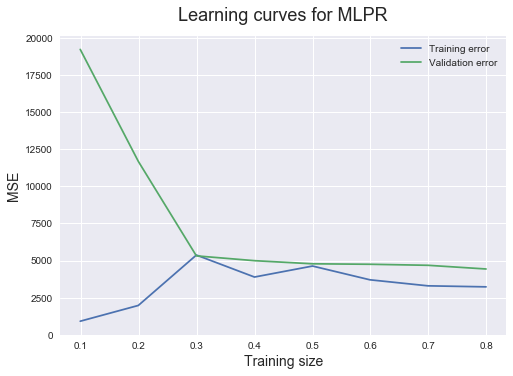

In [14]:

train_sizes = ((np.zeros((1, 8)) + x.shape[0]) * np.array(
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])).astype(int)

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=mlpr,
    X=x,
    y=y,
    train_sizes=train_sizes,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1)

train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)
plt.style.use('seaborn')
plt.plot(train_sizes / x.shape[0], train_scores_mean, label='Training error')
plt.plot(train_sizes / x.shape[0],
         validation_scores_mean, label='Validation error')
plt.ylabel('MSE', fontsize=14)
plt.xlabel('Training size', fontsize=14)
plt.title('Learning curves for MLPR', fontsize=18, y=1.03)
plt.legend()


  ## Comparison of predicted and actual target value (Table)

In [15]:
def percentage_diff(predict, actual):
    if predict == actual or actual == 0 or predict == 0:
        return 0
    try:
        return round((abs(predict - actual) / actual) * 100.0, 3)
    except ZeroDivisionError:
        return 0

comparison = pd.concat([pd.Series(np.array(y_test)), pd.Series(mlpr_predict)], axis=1, sort=False)
comparison[2] = np.absolute(comparison[0] - comparison[1])

percent = []
for i in range(0, comparison[0].size):
    percent.append(float(percentage_diff(comparison[1][i], comparison[0][i])))
comparison[3] = percent

comparison.rename(columns={0: 'Actual Revenue', 1: 'Predicted Revenue',
                           2: 'Difference', 3: '% Diff.'}, inplace=True)

comparison.sample(10)



,Actual Revenue,Predicted Revenue,Difference,% Diff.
186,107.50,110.747290,3.247290,3.021
158,70.27,57.835902,12.434098,17.695
23,0.54,50.884544,50.344544,9323.064
121,47.17,143.091793,95.921793,203.353
200,132.37,270.339143,137.969143,104.230
87,28.75,88.144198,59.394198,206.589
179,95.00,19.222889,75.777111,79.765
117,46.01,38.662472,7.347528,15.969
175,91.12,141.760460,50.640460,55.576
42,5.69,94.731496,89.041496,1564.877


In [16]:
print(f"Average diff. (in million) : {np.average(comparison['Difference'])}")
print(f"Average diff. percentage : {np.average(comparison['% Diff.'])}")


Average diff. (in million) : 42.2387774000421
Average diff. percentage : 4843.605226190476


  ## Comparison of predicted and actual target value (Curve Graph)
  * Red point : actual revenue
  * Blue line : predicted revenue

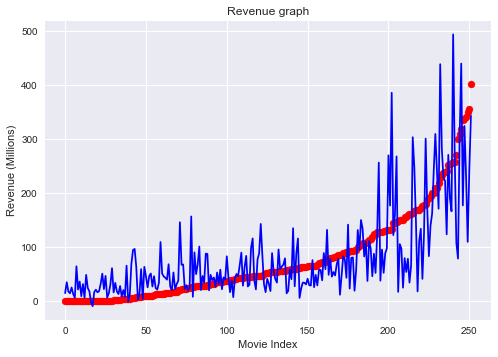

In [17]:
index_x = [i for i in range(0, y_test.size)]

plt.style.use('seaborn')
plt.scatter(index_x, y_test, color='red')
# plt.scatter(index_x, y_test, color='red')
plt.plot(index_x, mlpr_predict, color='blue')
# plt.scatter(index_x, mlpr_predict, color='blue')

plt.title('Revenue graph')
plt.xlabel('Movie Index')
plt.ylabel('Revenue (Millions)')

plt.show()
